In [14]:
from functools import partial
import jax
import os
import html
import numpy as np

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.envs.original import Pendulum 
from src.envs.realistic import RealisticPendulum 
from src.dyn_model.Predict import pretrained_params




In [15]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [16]:
env = Pendulum.Pendulum()
env1 = RealisticPendulum.RealisticPendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

11
11


In [17]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

In [18]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.plot(x_data, y_data)
    plt.show()

# policy_hds = train_hds(env,trajectory_length=100 ,num_samples=100,epochs=20, inner_epochs=20, alpha_a=8e-5, aggregation_factor_beta=0.175,
#                        init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f) 

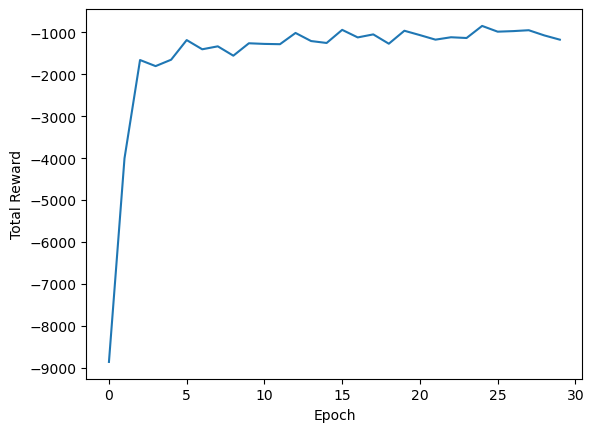

big epoch: 29 small epoch: 0 Loss 1.4851860341972686e-05
big epoch: 29 small epoch: 1 Loss 0.00011083368754540147
big epoch: 29 small epoch: 2 Loss 0.00031004011126793094
big epoch: 29 small epoch: 3 Loss 0.00014037665656820017
big epoch: 29 small epoch: 4 Loss 0.00019388111291261404
big epoch: 29 small epoch: 5 Loss 2.5435064459538655e-05
big epoch: 29 small epoch: 6 Loss 0.0001119979590380351
big epoch: 29 small epoch: 7 Loss 0.00016011207566365906
big epoch: 29 small epoch: 8 Loss 4.8078007782313655e-05
big epoch: 29 small epoch: 9 Loss 4.421579705268606e-05
big epoch: 29 small epoch: 10 Loss 0.00011522828639567416
big epoch: 29 small epoch: 11 Loss 2.057072436759741e-05
big epoch: 29 small epoch: 12 Loss 0.00014084207895618433
big epoch: 29 small epoch: 13 Loss 1.7588364197690813e-05
big epoch: 29 small epoch: 14 Loss 0.00010810230809024178
big epoch: 29 small epoch: 15 Loss 3.821269759350557e-05
big epoch: 29 small epoch: 16 Loss 0.00016775518844251448
big epoch: 29 small epoch: 1

In [19]:
policy_pods = train_pods(env,trajectory_length=100 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a=2e-4, init_learning_rate=1e-3, progress_fn=progress_f)


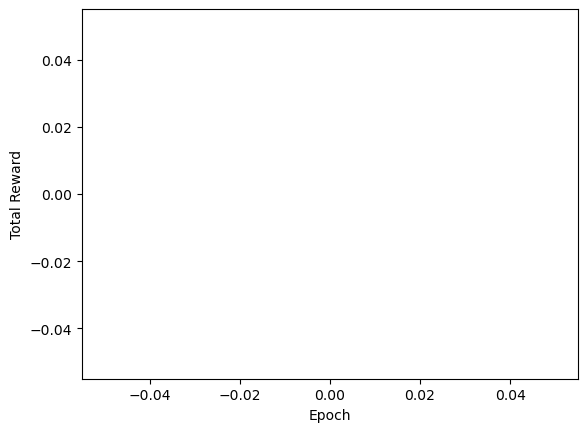

In [31]:
policy_hds = train_hds(env,trajectory_length=500 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a=2e-4, aggregation_factor_beta=1.0, init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.5, progress_fn=progress_f) 

In [28]:
realistic_env = RealisticPendulum.RealisticPendulum()
inference_fn_hds = policy_hds()
#inference_fn_pods = policy_pods()
# inference_fn_hds = policy_hds()

@partial(jax.vmap, in_axes=(None, None, None, 0), axis_name="batch")
def rollout_policy(
        env, inference_fn, trajectory_length: int, prng_keys
    ):

    def step_trajectory(state_carry, rng_key):
        action = inference_fn(state_carry.obs)
        next_state = env.step(state_carry, action)
        return next_state, (state_carry.obs, action, next_state.reward)

    state = env.reset(prng_keys)
    keys = jax.random.split(prng_keys, trajectory_length)
    _, (states, actions, rewards_future) = jax.lax.scan(
        step_trajectory, state, xs=keys
    )

    states = jax.numpy.reshape(
        states, (trajectory_length, env.observation_size)
    )
    actions = jax.numpy.reshape(
        actions, (trajectory_length, env.action_size)
    )

    totalreward = jp.sum(rewards_future)

    return states, actions, totalreward

# prng_key = jax.random.PRNGKey(seed=0)
# subkeys = jax.random.split(prng_key, num=50)

# _, _ , rewards_original_pods  = rollout_policy(env, inference_fn_pods, 100, subkeys)
# _, _ , rewards_realistic_pods = rollout_policy(realistic_env, inference_fn_pods, 100, subkeys)
# _, _ , rewards_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)
# _, _ , rewards_hds_train_env = rollout_policy(env, inference_fn_hds, 100, subkeys)

# _, _ , rewards_original_hds  = rollout_policy(env, inference_fn_hds, 100, subkeys)
# _, _ , rewards_realistic_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)

# average_reward_original_pods = jp.mean(rewards_original_pods)
# average_reward_realistic = jp.mean(rewards_realistic_pods)
# average_reward_original_hds = jp.mean(rewards_original_hds)
# average_reward_realistic_hds = jp.mean(rewards_realistic_hds)

# average_reward_hds = jp.mean(rewards_hds)
# average_reward_hds_train_env = jp.mean(rewards_hds_train_env)

11


In [30]:
totalreward1 = []
totalreward2 = []
totalreward3 = []

for i in range(100):
    print(i)
    rng = jax.random.PRNGKey(seed=i)
    keys = jax.random.split(rng, num=50)
    # _,_,total_reward_1 = rollout_policy(env, inference_fn_pods, 100, keys)
    # _,_,total_reward_2 = rollout_policy(realistic_env, inference_fn_pods, 100, keys)
    _,_,total_reward_3 = rollout_policy(realistic_env, inference_fn_hds, 100, keys)
    # totalreward1.append(total_reward_1)
    # totalreward2.append(total_reward_2)
    totalreward3.append(total_reward_3)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

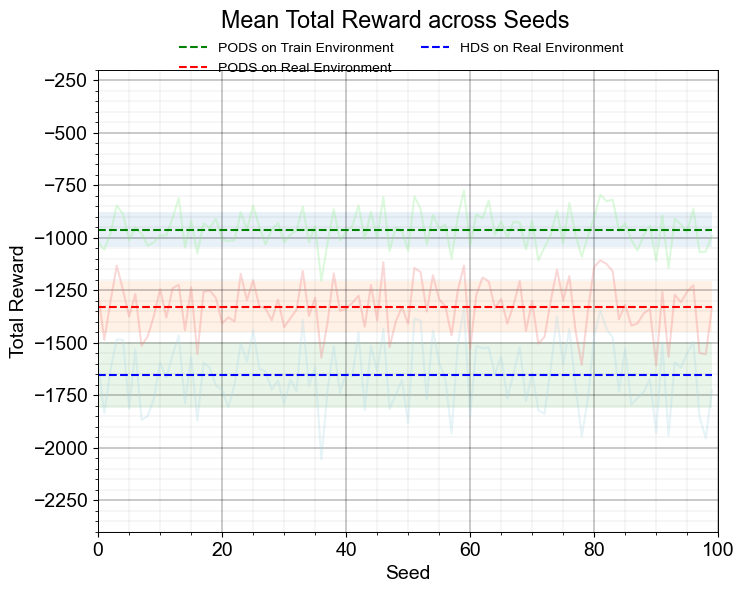

In [ ]:
totalreward11 = np.empty(100)   
totalreward22 = np.empty(100)
totalreward33 = np.empty(100)
for i in range(100):
    totalreward11[i] = jp.mean(totalreward1[i])
    totalreward22[i] = jp.mean(totalreward2[i])
    totalreward33[i] = jp.mean(totalreward3[i])

meantotalrew1 = jp.mean(totalreward11)*jp.ones(100)
meantotalrew2 = jp.mean(totalreward22)*jp.ones(100)
meantotalrew3 = jp.mean(totalreward33)*jp.ones(100)
vartotalrew1 = jp.std(totalreward11)*jp.ones(100)
vartotalrew2 = jp.std(totalreward22)*jp.ones(100)
vartotalrew3 = jp.std(totalreward33)*jp.ones(100)

plt.figure(figsize=(8, 6), dpi=100)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
plt.rcParams['axes.linewidth'] = 0.7


plt.suptitle('Mean Total Reward across Seeds ')
plt.plot(totalreward11, color = 'lightgreen',alpha=0.3)
plt.plot(totalreward22, color='lightcoral',alpha=0.3)
plt.plot(totalreward33, color='lightblue',alpha=0.3)
plt.fill_between(np.arange(0,100),meantotalrew1+vartotalrew1,meantotalrew1-vartotalrew1,alpha=0.1)
plt.fill_between(np.arange(0,100),meantotalrew2+vartotalrew2,meantotalrew2-vartotalrew2,alpha=0.1)
plt.fill_between(np.arange(0,100),meantotalrew3+vartotalrew3,meantotalrew3-vartotalrew3,alpha=0.1)

plt.plot(meantotalrew1, label='PODS on Train Environment', color='green' ,linestyle='--')
plt.plot(meantotalrew2, label='PODS on Real Environment', color='red',linestyle='--')
plt.plot(meantotalrew3, label='HDS on Real Environment', color='blue',linestyle='--')

plt.xlim(0, 100)
plt.ylim(-2400, -200)
plt.grid(True)
plt.grid(which='minor', linestyle='-', linewidth='0.05', color='black')
plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
plt.minorticks_on()
plt.legend(loc=9,frameon=False,ncols=2,bbox_to_anchor=(0.489, 1.086, 0., 0.),fontsize=10)
plt.xlabel('Seed')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
print(f'PODS on real environment {jp.mean(jp.array(average_reward_realistic))}')
print(f'PODS on train environment {jp.mean(jp.array(average_reward_original_pods))}')
print(f'HDS on real environment {jp.mean(jp.array(average_reward_realistic_hds))}')
print(f'HDS on train environment {jp.mean(jp.array(average_reward_original_hds))}')
print(f'HDS on real environment {jp.mean(jp.array(average_reward_hds))}')
print(f'HDS on train environment {jp.mean(jp.array(average_reward_hds_train_env))}')

NameError: name 'average_reward_realistic' is not defined

In [ ]:
seeds = [x for x in range(100)]
plt.figure(figsize=(10, 6))
plt.plot(seeds, rewards_realistic, label='PODS on Real Environment', color='blue')
plt.plot(seeds, rewards_original_pods, label='PODS on Train Environment', color='red')
plt.plot(seeds, rewards_hds, label='HDS on Real Environment (Ours)', color='green')
plt.plot(seeds, rewards_hds_train_env, label='HDS on Train Environment (Ours)', color='orange')
plt.xlabel('Seed')
plt.ylabel('Total Reward')
plt.title('Total Reward across Seeds')
plt.legend()
plt.grid(True)
plt.show()

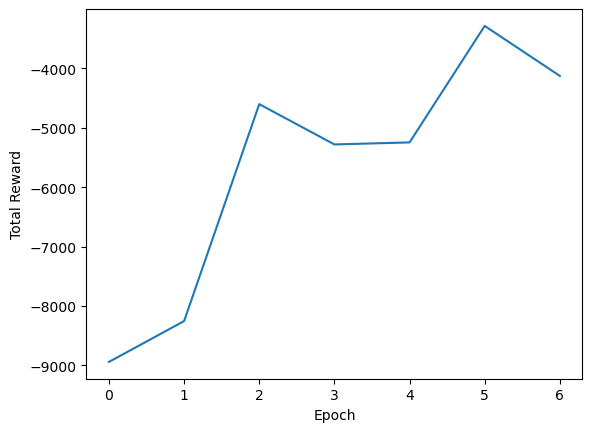

big epoch: 6 small epoch: 0 Loss 3.9676249379076835e-05
big epoch: 6 small epoch: 1 Loss 0.0004167686927570929
big epoch: 6 small epoch: 2 Loss 0.000268699122681688
big epoch: 6 small epoch: 3 Loss 5.1014645902218114e-05
big epoch: 6 small epoch: 4 Loss 5.6788052546333806e-05
big epoch: 6 small epoch: 5 Loss 6.1032509112137045e-05
big epoch: 6 small epoch: 6 Loss 5.4770320696805665e-05
big epoch: 6 small epoch: 7 Loss 9.412219008024338e-05
big epoch: 6 small epoch: 8 Loss 4.247467481500143e-05
big epoch: 6 small epoch: 9 Loss 7.947348776439825e-05
big epoch: 6 small epoch: 10 Loss 9.030178799871568e-05
big epoch: 6 small epoch: 11 Loss 8.387125078410205e-05
big epoch: 6 small epoch: 12 Loss 5.159727700581531e-05
big epoch: 6 small epoch: 13 Loss 7.023835591575672e-05
big epoch: 6 small epoch: 14 Loss 4.0575042100862615e-05
big epoch: 6 small epoch: 15 Loss 4.161650612528967e-05
big epoch: 6 small epoch: 16 Loss 3.428878459647493e-05
big epoch: 6 small epoch: 17 Loss 5.5908458235892876e

In [ ]:
def run_over_aggregation_factor(aggregation_factor_beta):
    policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=20, inner_epochs=20, alpha_a=2e-5, aggregation_factor_beta=aggregation_factor_beta,
                       init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.0, progress_fn=progress_f) 
    inference_fn = policy()
    
    prng_key = jax.random.PRNGKey(seed=0)
    subkeys = jax.random.split(prng_key, num=50)
    _, _ , rewards_hds_real_env  = rollout_policy(realistic_env, inference_fn, 100, subkeys)
    average_reward_hds_real_env = jp.mean(rewards_hds_real_env)
    print(aggregation_factor_beta)
    del policy
    del inference_fn
    return average_reward_hds_real_env

aggregation_factors = np.linspace(0.0,0.3,5)

rewards_dep_aggregation_factor = [run_over_aggregation_factor(x) for x in aggregation_factors]
rewards_pods_real_env = [average_reward_realistic for _ in aggregation_factors]
rewards_pods_train_env = [average_reward_original_pods for _ in aggregation_factors]

plt.figure(figsize=(10, 6))
clear_output(wait=True)
plt.plot(aggregation_factors, rewards_dep_aggregation_factor, label='HDS on Real Environment (Ours)', color='green')
plt.plot(aggregation_factors, rewards_pods_real_env, label='PODS on Real Environment, Mean', color='red')
plt.plot(aggregation_factors, rewards_pods_train_env, label='PODS on Train Environment, Mean', color='blue')
plt.legend()
plt.xlabel('Aggregation Factor')
plt.ylabel('Total Reward')
plt.title('Total Reward across Aggregation Factors')
plt.grid(True)
plt.show()



In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy_pods()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env1.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env1.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.99999851]
[0.99999597]
[0.99999]
[0.99998001]
[0.99996562]
[0.99992744]
[0.99980654]
[0.99960449]
[0.99882135]
[0.99741403]
[0.9938824]
[0.9835202]
[0.9527484]
[0.88545456]
[0.80250161]
[0.76309756]
[0.77679301]
[0.7985496]
[0.74881424]
[0.69584568]
[0.68176168]
[0.65967673]
[0.61755093]
[0.55293261]
[0.50797814]
[0.48426198]
[0.470213]
[0.45987339]
[0.45528204]
[0.4480364]
[0.43175174]
[0.41348387]
[0.405974]
[0.39655573]
[0.37982773]
[0.36158432]
[0.35143556]
[0.34608093]
[0.33783892]
[0.32428915]
[0.31032029]
[0.30175106]
[0.29654831]
[0.29201191]
[0.28504996]
[0.27567828]
[0.2646946]
[0.25261988]
[0.23784688]
[0.21887328]
[0.19828135]
[0.17817999]
[0.15996168]
[0.09841726]
[0.0973999]
[0.09439956]
[0.08980755]
[0.08720799]
[0.08493301]
[0.08325962]
[0.0806371]
[0.07706094]
[0.07487741]
[0.07298044]
[0.06742815]
[0.05975806]
[0.05286606]
[0.04630615]
[0.03936228]
[0.03323983]
[0.03371232]
[0.03444062]
[0.03945377]
[0.04901753]
[0.0515736]
[0.05139738]
[0.04700381]
[0.0412056]
[0.

In [ ]:

yes=html.render(env.sys.replace(), rollout)
with open("data.html", "w") as file:
    file.write(yes)